In [363]:
import numpy as np
import pandas as pd

# create example data
data = pd.read_csv("rainfall_data.csv")
data=data.iloc[:,3:]
# calculate 95th percentile for each column
percentiles = data.quantile(0.95)

# find rows with values above the 95th percentile
above_95th = data[(data > percentiles).all(axis=1)]

print(above_95th)


       rainfall
6     24.932436
7     23.246956
41    33.846075
64    23.561225
83    22.738915
...         ...
2534  21.900691
2538  24.230811
2541  22.366934
2551  34.073259
2552  21.649361

[129 rows x 1 columns]


In [364]:
import pandas as pd
data = pd.read_csv("rainfall_data.csv")
data=data.iloc[:,3:]
# calculate 95th percentile for each column
percentiles = data.quantile(0.95)

# filter rows above 95th percentile for each column
filtered_data = data[(data > percentiles).any(axis=1)]




print(filtered_data)


       rainfall
6     24.932436
7     23.246956
41    33.846075
64    23.561225
83    22.738915
...         ...
2534  21.900691
2538  24.230811
2541  22.366934
2551  34.073259
2552  21.649361

[129 rows x 1 columns]


In [365]:
percentiles

rainfall    20.807473
Name: 0.95, dtype: float64

In [366]:
data = pd.read_csv("rainfall_data.csv")
# label extreme rows in original dataframe
data['rainfall_class'] = 'normal'
data.loc[data.index.isin(filtered_data.index), 'rainfall_class'] = 'extreme'


In [367]:
(data[data["rainfall"]>20.807473]).count()

date              129
windspeed         129
tpw               129
rainfall          129
rainfall_class    129
dtype: int64

In [368]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your data into a Pandas DataFrame
df = data

# Separate your data into normal and extreme classes
normal_data = df[df['rainfall_class'] == 'normal']
extreme_data = df[df['rainfall_class'] == 'extreme']

# Split the normal data into training and testing sets
normal_train, normal_test = train_test_split(normal_data[['windspeed', 'tpw', 'rainfall']], test_size=0.2, random_state=42)

# Split the extreme data into training and testing sets
extreme_train, extreme_test = train_test_split(extreme_data[['windspeed', 'tpw', 'rainfall']], test_size=0.2, random_state=42)

# Combine the training and testing sets for each class
train_data = pd.concat([normal_train, extreme_train])
test_data = pd.concat([normal_test, extreme_test])

# Print the class distribution in the training and testing sets
#train_normal_count = len(train_data[train_data['rainfall_class'] == 'normal'])
#train_extreme_count = len(train_data[train_data['rainfall_class'] == 'extreme'])
#test_normal_count = len(test_data[test_data['rainfall_class'] == 'normal'])
#test_extreme_count = len(test_data[test_data['rainfall_class'] == 'extreme'])

#print(f"Training set: normal={train_normal_count}, extreme={train_extreme_count}")
#print(f"Testing set: normal={test_normal_count}, extreme={test_extreme_count}")


In [369]:
print(train_data[train_data["rainfall"]<20.807473].count())
print(test_data[test_data["rainfall"]<20.807473].count())

windspeed    1946
tpw          1946
rainfall     1946
dtype: int64
windspeed    487
tpw          487
rainfall     487
dtype: int64


In [370]:
import numpy as np
import copy
import tensorflow as tf
from sklearn import preprocessing
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from keras import backend as K
import os
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import seed
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



In [371]:
def weighted_loss(normal_weight=1, extreme_weight=0.0001):
    def loss(y_true, y_pred):
        normal_loss = K.mean(K.square(y_true[:, :3] - y_pred[:, :3])* K.cast(y_true[:, 2:] <= 20.807473, 'float32'))
        extreme_loss = K.mean(K.square(y_true[:, :3] - y_pred[:, :3]) * K.cast(y_true[:, 2:] > 20.807473, 'float32'))
        #rain_weight = normal_weight * (y_true[:, 2:]) + extreme_weight * y_true[:, 2:]
        #return K.mean(rain_weight * K.sum(y_true[:, :2] - y_pred[:, 2:]) + normal_loss + extreme_loss)
        return K.mean(abs(normal_weight * normal_loss) + abs(extreme_weight * extreme_loss))
    return loss


In [372]:

def find_best_reg_strength(train_data, reg_strengths, num_epochs, batch_size):
    best_reg_strength = None
    best_loss = float('inf')
    for reg_strength in reg_strengths:
        # Define the autoencoder architecture
        input_layer = Input(shape=(3,))
        encoded = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=reg_strength))(input_layer)
        decoded = Dense(3, activation=None)(encoded)

        # Create the autoencoder
        autoencoder = Model(input_layer, decoded)

        # Compile the autoencoder with the weighted loss function
        #autoencoder.compile(optimizer='adam', loss="mse")
        autoencoder.compile(optimizer='adam', loss=weighted_loss())
        # Train the model
        history = autoencoder.fit(train_data, train_data, epochs=num_epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
        #history = autoencoder.fit(train_data,epochs=num_epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

        # Calculate the validation loss
        val_loss = np.mean(history.history['val_loss'])

        # Update the best regularization strength and loss
        if val_loss < best_loss:
            best_reg_strength = reg_strength
            best_loss = val_loss

    print('Best regularization strength:', best_reg_strength)
    return best_reg_strength

In [373]:

reg_strengths = [0.1, 1, 10, 100]
num_epochs = 3000
batch_size = 100
#train_data = normal_data[["windspeed_discretized","tpw_discretized"]].values.astype("float32")
#train_data = normal_data[["windspeed","tpw","rainfall"]].values.astype("float32")

#best_reg_strength = find_best_reg_strength(train_data, reg_strengths, num_epochs, batch_size)

# Define the autoencoder architecture with the best regularization strength
input_layer = Input(shape=(3,),name='input')
encoded = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=20),name='encoder')(input_layer)
decoded = Dense(3, activation=None, name='decoder')(encoded)

# Create the autoencoder
autoencoder = Model(input_layer, decoded)

# Compile the autoencoder with the weighted loss function
#autoencoder.compile(optimizer='adam', loss="mse")
autoencoder.compile(optimizer='adam', loss=weighted_loss())

# Train the model with the majority class
history = autoencoder.fit(train_data, train_data, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)
#history = autoencoder.fit(train_data,epochs=num_epochs, batch_size=batch_size, validation_split=0.2, verbose=0)


Epoch 1/3000
17/17 [==============================] - 1s 24ms/step - loss: 190.4903 - val_loss: 161.7408
Epoch 2/3000
17/17 [==============================] - 0s 8ms/step - loss: 173.7800 - val_loss: 147.9085
Epoch 3/3000
17/17 [==============================] - 0s 4ms/step - loss: 158.5737 - val_loss: 135.1267
Epoch 4/3000
17/17 [==============================] - 0s 5ms/step - loss: 144.4456 - val_loss: 123.2765
Epoch 5/3000
17/17 [==============================] - 0s 3ms/step - loss: 131.2793 - val_loss: 112.2887
Epoch 6/3000
17/17 [==============================] - 0s 4ms/step - loss: 118.9341 - val_loss: 102.1310
Epoch 7/3000
17/17 [==============================] - 0s 3ms/step - loss: 107.5449 - val_loss: 92.7444
Epoch 8/3000
17/17 [==============================] - 0s 4ms/step - loss: 96.9468 - val_loss: 84.0860
Epoch 9/3000
17/17 [==============================] - 0s 3ms/step - loss: 87.2293 - val_loss: 76.1624
Epoch 10/3000
17/17 [==============================] - 0s 3ms/step -

17/17 [==============================] - 0s 3ms/step - loss: 4.2908 - val_loss: 3.8412
Epoch 82/3000
17/17 [==============================] - 0s 3ms/step - loss: 4.2635 - val_loss: 3.8161
Epoch 83/3000
17/17 [==============================] - 0s 3ms/step - loss: 4.2288 - val_loss: 3.7838
Epoch 84/3000
17/17 [==============================] - 0s 3ms/step - loss: 4.1930 - val_loss: 3.7578
Epoch 85/3000
17/17 [==============================] - 0s 3ms/step - loss: 4.1624 - val_loss: 3.7237
Epoch 86/3000
17/17 [==============================] - 0s 3ms/step - loss: 4.1367 - val_loss: 3.6981
Epoch 87/3000
17/17 [==============================] - 0s 3ms/step - loss: 4.1038 - val_loss: 3.6759
Epoch 88/3000
17/17 [==============================] - 0s 3ms/step - loss: 4.0762 - val_loss: 3.6469
Epoch 89/3000
17/17 [==============================] - 0s 3ms/step - loss: 4.0513 - val_loss: 3.6304
Epoch 90/3000
17/17 [==============================] - 0s 3ms/step - loss: 4.0233 - val_loss: 3.5977
Epoc

17/17 [==============================] - 0s 3ms/step - loss: 2.5837 - val_loss: 2.3602
Epoch 162/3000
17/17 [==============================] - 0s 3ms/step - loss: 2.5680 - val_loss: 2.3455
Epoch 163/3000
17/17 [==============================] - 0s 3ms/step - loss: 2.5531 - val_loss: 2.3300
Epoch 164/3000
17/17 [==============================] - 0s 3ms/step - loss: 2.5389 - val_loss: 2.3140
Epoch 165/3000
17/17 [==============================] - 0s 3ms/step - loss: 2.5243 - val_loss: 2.3016
Epoch 166/3000
17/17 [==============================] - 0s 3ms/step - loss: 2.5087 - val_loss: 2.2927
Epoch 167/3000
17/17 [==============================] - 0s 3ms/step - loss: 2.4951 - val_loss: 2.2855
Epoch 168/3000
17/17 [==============================] - 0s 3ms/step - loss: 2.4807 - val_loss: 2.2664
Epoch 169/3000
17/17 [==============================] - 0s 4ms/step - loss: 2.4647 - val_loss: 2.2534
Epoch 170/3000
17/17 [==============================] - 0s 3ms/step - loss: 2.4518 - val_loss: 2.

17/17 [==============================] - 0s 3ms/step - loss: 1.6853 - val_loss: 1.5617
Epoch 242/3000
17/17 [==============================] - 0s 3ms/step - loss: 1.6775 - val_loss: 1.5505
Epoch 243/3000
17/17 [==============================] - 0s 3ms/step - loss: 1.6608 - val_loss: 1.5374
Epoch 244/3000
17/17 [==============================] - 0s 3ms/step - loss: 1.6460 - val_loss: 1.5190
Epoch 245/3000
17/17 [==============================] - 0s 3ms/step - loss: 1.6320 - val_loss: 1.5156
Epoch 246/3000
17/17 [==============================] - 0s 3ms/step - loss: 1.6132 - val_loss: 1.4934
Epoch 247/3000
17/17 [==============================] - 0s 3ms/step - loss: 1.5977 - val_loss: 1.4820
Epoch 248/3000
17/17 [==============================] - 0s 4ms/step - loss: 1.5849 - val_loss: 1.4641
Epoch 249/3000
17/17 [==============================] - 0s 3ms/step - loss: 1.5704 - val_loss: 1.4504
Epoch 250/3000
17/17 [==============================] - 0s 4ms/step - loss: 1.5575 - val_loss: 1.

17/17 [==============================] - 0s 3ms/step - loss: 1.0324 - val_loss: 0.9668
Epoch 322/3000
17/17 [==============================] - 0s 3ms/step - loss: 1.0238 - val_loss: 0.9574
Epoch 323/3000
17/17 [==============================] - 0s 3ms/step - loss: 1.0179 - val_loss: 0.9566
Epoch 324/3000
17/17 [==============================] - 0s 3ms/step - loss: 1.0141 - val_loss: 0.9528
Epoch 325/3000
17/17 [==============================] - 0s 3ms/step - loss: 1.0086 - val_loss: 0.9481
Epoch 326/3000
17/17 [==============================] - 0s 3ms/step - loss: 1.0059 - val_loss: 0.9418
Epoch 327/3000
17/17 [==============================] - 0s 3ms/step - loss: 1.0006 - val_loss: 0.9387
Epoch 328/3000
17/17 [==============================] - 0s 3ms/step - loss: 0.9936 - val_loss: 0.9322
Epoch 329/3000
17/17 [==============================] - 0s 3ms/step - loss: 0.9891 - val_loss: 0.9305
Epoch 330/3000
17/17 [==============================] - 0s 3ms/step - loss: 0.9859 - val_loss: 0.

17/17 [==============================] - 0s 3ms/step - loss: 0.7232 - val_loss: 0.6904
Epoch 402/3000
17/17 [==============================] - 0s 3ms/step - loss: 0.7207 - val_loss: 0.6880
Epoch 403/3000
17/17 [==============================] - 0s 3ms/step - loss: 0.7172 - val_loss: 0.6865
Epoch 404/3000
17/17 [==============================] - 0s 3ms/step - loss: 0.7144 - val_loss: 0.6823
Epoch 405/3000
17/17 [==============================] - 0s 3ms/step - loss: 0.7119 - val_loss: 0.6797
Epoch 406/3000
17/17 [==============================] - 0s 3ms/step - loss: 0.7108 - val_loss: 0.6779
Epoch 407/3000
17/17 [==============================] - 0s 3ms/step - loss: 0.7063 - val_loss: 0.6747
Epoch 408/3000
17/17 [==============================] - 0s 3ms/step - loss: 0.7032 - val_loss: 0.6722
Epoch 409/3000
17/17 [==============================] - 0s 3ms/step - loss: 0.7002 - val_loss: 0.6699
Epoch 410/3000
17/17 [==============================] - 0s 3ms/step - loss: 0.6973 - val_loss: 0.

17/17 [==============================] - 0s 5ms/step - loss: 0.5354 - val_loss: 0.5182
Epoch 482/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.5333 - val_loss: 0.5174
Epoch 483/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.5305 - val_loss: 0.5162
Epoch 484/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.5295 - val_loss: 0.5136
Epoch 485/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.5273 - val_loss: 0.5124
Epoch 486/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.5264 - val_loss: 0.5100
Epoch 487/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.5232 - val_loss: 0.5079
Epoch 488/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.5230 - val_loss: 0.5105
Epoch 489/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.5207 - val_loss: 0.5046
Epoch 490/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.5183 - val_loss: 0.

17/17 [==============================] - 0s 5ms/step - loss: 0.4104 - val_loss: 0.4016
Epoch 562/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.4092 - val_loss: 0.4009
Epoch 563/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.4075 - val_loss: 0.3989
Epoch 564/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.4065 - val_loss: 0.3984
Epoch 565/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.4053 - val_loss: 0.3971
Epoch 566/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.4040 - val_loss: 0.3970
Epoch 567/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.4040 - val_loss: 0.4007
Epoch 568/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.4050 - val_loss: 0.3943
Epoch 569/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.4007 - val_loss: 0.3926
Epoch 570/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.3999 - val_loss: 0.

17/17 [==============================] - 0s 5ms/step - loss: 0.3245 - val_loss: 0.3189
Epoch 642/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.3223 - val_loss: 0.3189
Epoch 643/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.3224 - val_loss: 0.3175
Epoch 644/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.3203 - val_loss: 0.3164
Epoch 645/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.3191 - val_loss: 0.3149
Epoch 646/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.3182 - val_loss: 0.3143
Epoch 647/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.3176 - val_loss: 0.3150
Epoch 648/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.3169 - val_loss: 0.3122
Epoch 649/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.3154 - val_loss: 0.3122
Epoch 650/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.3151 - val_loss: 0.

17/17 [==============================] - 0s 5ms/step - loss: 0.2624 - val_loss: 0.2581
Epoch 722/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.2617 - val_loss: 0.2577
Epoch 723/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.2591 - val_loss: 0.2571
Epoch 724/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.2592 - val_loss: 0.2578
Epoch 725/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.2585 - val_loss: 0.2559
Epoch 726/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.2574 - val_loss: 0.2568
Epoch 727/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.2568 - val_loss: 0.2547
Epoch 728/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.2562 - val_loss: 0.2543
Epoch 729/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.2552 - val_loss: 0.2531
Epoch 730/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.2549 - val_loss: 0.

17/17 [==============================] - 0s 5ms/step - loss: 0.2156 - val_loss: 0.2145
Epoch 802/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.2149 - val_loss: 0.2143
Epoch 803/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.2144 - val_loss: 0.2128
Epoch 804/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.2139 - val_loss: 0.2126
Epoch 805/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.2137 - val_loss: 0.2140
Epoch 806/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.2134 - val_loss: 0.2128
Epoch 807/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.2136 - val_loss: 0.2118
Epoch 808/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.2131 - val_loss: 0.2121
Epoch 809/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.2127 - val_loss: 0.2107
Epoch 810/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.2115 - val_loss: 0.

17/17 [==============================] - 0s 5ms/step - loss: 0.1820 - val_loss: 0.1810
Epoch 882/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1815 - val_loss: 0.1819
Epoch 883/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1819 - val_loss: 0.1806
Epoch 884/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1826 - val_loss: 0.1818
Epoch 885/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1813 - val_loss: 0.1815
Epoch 886/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1811 - val_loss: 0.1793
Epoch 887/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.1808 - val_loss: 0.1796
Epoch 888/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1805 - val_loss: 0.1795
Epoch 889/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1801 - val_loss: 0.1787
Epoch 890/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.1799 - val_loss: 0.

17/17 [==============================] - 0s 5ms/step - loss: 0.1571 - val_loss: 0.1563
Epoch 962/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1569 - val_loss: 0.1559
Epoch 963/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1565 - val_loss: 0.1555
Epoch 964/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1562 - val_loss: 0.1567
Epoch 965/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1566 - val_loss: 0.1563
Epoch 966/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1561 - val_loss: 0.1550
Epoch 967/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1554 - val_loss: 0.1554
Epoch 968/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.1553 - val_loss: 0.1546
Epoch 969/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1551 - val_loss: 0.1553
Epoch 970/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1563 - val_loss: 0.

17/17 [==============================] - 0s 5ms/step - loss: 0.1380 - val_loss: 0.1369
Epoch 1042/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1375 - val_loss: 0.1367
Epoch 1043/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1372 - val_loss: 0.1365
Epoch 1044/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1373 - val_loss: 0.1372
Epoch 1045/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1373 - val_loss: 0.1362
Epoch 1046/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1366 - val_loss: 0.1361
Epoch 1047/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1366 - val_loss: 0.1364
Epoch 1048/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1382 - val_loss: 0.1378
Epoch 1049/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1372 - val_loss: 0.1388
Epoch 1050/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1373 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.1232 - val_loss: 0.1229
Epoch 1121/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1227 - val_loss: 0.1222
Epoch 1122/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1226 - val_loss: 0.1218
Epoch 1123/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1222 - val_loss: 0.1218
Epoch 1124/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1223 - val_loss: 0.1217
Epoch 1125/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1220 - val_loss: 0.1220
Epoch 1126/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1222 - val_loss: 0.1222
Epoch 1127/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1222 - val_loss: 0.1212
Epoch 1128/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1218 - val_loss: 0.1217
Epoch 1129/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1223 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.1110 - val_loss: 0.1105
Epoch 1200/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1107 - val_loss: 0.1106
Epoch 1201/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1110 - val_loss: 0.1105
Epoch 1202/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1112 - val_loss: 0.1101
Epoch 1203/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1113 - val_loss: 0.1101
Epoch 1204/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1104 - val_loss: 0.1110
Epoch 1205/3000
17/17 [==============================] - 0s 6ms/step - loss: 0.1117 - val_loss: 0.1102
Epoch 1206/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1109 - val_loss: 0.1099
Epoch 1207/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1100 - val_loss: 0.1092
Epoch 1208/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1100 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.1017 - val_loss: 0.1011
Epoch 1279/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1015 - val_loss: 0.1012
Epoch 1280/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.1017 - val_loss: 0.1010
Epoch 1281/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1013 - val_loss: 0.1006
Epoch 1282/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1013 - val_loss: 0.1015
Epoch 1283/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.1020 - val_loss: 0.1005
Epoch 1284/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1012 - val_loss: 0.1007
Epoch 1285/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1012 - val_loss: 0.1008
Epoch 1286/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1012 - val_loss: 0.1001
Epoch 1287/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.1008 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.0938 - val_loss: 0.0936
Epoch 1358/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0939 - val_loss: 0.0941
Epoch 1359/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0942 - val_loss: 0.0931
Epoch 1360/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0942 - val_loss: 0.0936
Epoch 1361/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0940 - val_loss: 0.0934
Epoch 1362/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0937 - val_loss: 0.0930
Epoch 1363/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0934 - val_loss: 0.0938
Epoch 1364/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0942 - val_loss: 0.0950
Epoch 1365/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0941 - val_loss: 0.0927
Epoch 1366/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0940 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.0888 - val_loss: 0.0916
Epoch 1437/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0899 - val_loss: 0.0877
Epoch 1438/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0883 - val_loss: 0.0866
Epoch 1439/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.0875 - val_loss: 0.0868
Epoch 1440/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0877 - val_loss: 0.0868
Epoch 1441/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.0871 - val_loss: 0.0870
Epoch 1442/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.0872 - val_loss: 0.0866
Epoch 1443/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0878 - val_loss: 0.0866
Epoch 1444/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0879 - val_loss: 0.0862
Epoch 1445/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0871 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.0823 - val_loss: 0.0815
Epoch 1516/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.0820 - val_loss: 0.0815
Epoch 1517/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0819 - val_loss: 0.0816
Epoch 1518/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0819 - val_loss: 0.0817
Epoch 1519/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0818 - val_loss: 0.0812
Epoch 1520/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0818 - val_loss: 0.0820
Epoch 1521/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0817 - val_loss: 0.0810
Epoch 1522/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.0815 - val_loss: 0.0818
Epoch 1523/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0828 - val_loss: 0.0815
Epoch 1524/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0825 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.0782 - val_loss: 0.0771
Epoch 1595/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0791 - val_loss: 0.0787
Epoch 1596/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0776 - val_loss: 0.0770
Epoch 1597/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0773 - val_loss: 0.0774
Epoch 1598/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0777 - val_loss: 0.0788
Epoch 1599/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0779 - val_loss: 0.0783
Epoch 1600/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0775 - val_loss: 0.0768
Epoch 1601/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0769 - val_loss: 0.0766
Epoch 1602/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0770 - val_loss: 0.0763
Epoch 1603/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0777 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.0739 - val_loss: 0.0731
Epoch 1674/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0734 - val_loss: 0.0729
Epoch 1675/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0732 - val_loss: 0.0729
Epoch 1676/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0734 - val_loss: 0.0729
Epoch 1677/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0735 - val_loss: 0.0731
Epoch 1678/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0731 - val_loss: 0.0727
Epoch 1679/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0731 - val_loss: 0.0726
Epoch 1680/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0731 - val_loss: 0.0729
Epoch 1681/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0729 - val_loss: 0.0728
Epoch 1682/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0730 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.0712 - val_loss: 0.0726
Epoch 1753/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0710 - val_loss: 0.0711
Epoch 1754/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0709 - val_loss: 0.0696
Epoch 1755/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0701 - val_loss: 0.0696
Epoch 1756/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0699 - val_loss: 0.0695
Epoch 1757/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0698 - val_loss: 0.0693
Epoch 1758/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0700 - val_loss: 0.0692
Epoch 1759/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0699 - val_loss: 0.0704
Epoch 1760/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0706 - val_loss: 0.0710
Epoch 1761/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0720 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.0671 - val_loss: 0.0669
Epoch 1832/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0674 - val_loss: 0.0668
Epoch 1833/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0679 - val_loss: 0.0713
Epoch 1834/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0696 - val_loss: 0.0698
Epoch 1835/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0701 - val_loss: 0.0667
Epoch 1836/3000
17/17 [==============================] - 0s 6ms/step - loss: 0.0685 - val_loss: 0.0678
Epoch 1837/3000
17/17 [==============================] - 0s 6ms/step - loss: 0.0685 - val_loss: 0.0681
Epoch 1838/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0680 - val_loss: 0.0681
Epoch 1839/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0671 - val_loss: 0.0665
Epoch 1840/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0668 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.0643 - val_loss: 0.0640
Epoch 1911/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0643 - val_loss: 0.0640
Epoch 1912/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0658 - val_loss: 0.0647
Epoch 1913/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0668 - val_loss: 0.0651
Epoch 1914/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0656 - val_loss: 0.0659
Epoch 1915/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0658 - val_loss: 0.0642
Epoch 1916/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0645 - val_loss: 0.0644
Epoch 1917/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0652 - val_loss: 0.0640
Epoch 1918/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0658 - val_loss: 0.0636
Epoch 1919/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0652 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.0618 - val_loss: 0.0614
Epoch 1990/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0621 - val_loss: 0.0620
Epoch 1991/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0625 - val_loss: 0.0618
Epoch 1992/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0622 - val_loss: 0.0621
Epoch 1993/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0627 - val_loss: 0.0618
Epoch 1994/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0623 - val_loss: 0.0613
Epoch 1995/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0617 - val_loss: 0.0614
Epoch 1996/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0618 - val_loss: 0.0617
Epoch 1997/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0618 - val_loss: 0.0613
Epoch 1998/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0620 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.0635 - val_loss: 0.0612
Epoch 2069/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0609 - val_loss: 0.0597
Epoch 2070/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0602 - val_loss: 0.0596
Epoch 2071/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0601 - val_loss: 0.0598
Epoch 2072/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0599 - val_loss: 0.0593
Epoch 2073/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0597 - val_loss: 0.0608
Epoch 2074/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0606 - val_loss: 0.0593
Epoch 2075/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0601 - val_loss: 0.0597
Epoch 2076/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0600 - val_loss: 0.0595
Epoch 2077/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0600 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.0590 - val_loss: 0.0588
Epoch 2148/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0591 - val_loss: 0.0578
Epoch 2149/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0581 - val_loss: 0.0576
Epoch 2150/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0579 - val_loss: 0.0579
Epoch 2151/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0580 - val_loss: 0.0579
Epoch 2152/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.0580 - val_loss: 0.0573
Epoch 2153/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0581 - val_loss: 0.0574
Epoch 2154/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0582 - val_loss: 0.0585
Epoch 2155/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0587 - val_loss: 0.0575
Epoch 2156/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0585 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.0564 - val_loss: 0.0565
Epoch 2227/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0561 - val_loss: 0.0555
Epoch 2228/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0561 - val_loss: 0.0559
Epoch 2229/3000
17/17 [==============================] - 0s 7ms/step - loss: 0.0564 - val_loss: 0.0558
Epoch 2230/3000
17/17 [==============================] - 0s 6ms/step - loss: 0.0563 - val_loss: 0.0563
Epoch 2231/3000
17/17 [==============================] - 0s 7ms/step - loss: 0.0583 - val_loss: 0.0616
Epoch 2232/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0615 - val_loss: 0.0596
Epoch 2233/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0582 - val_loss: 0.0556
Epoch 2234/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0574 - val_loss: 0.0556
Epoch 2235/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0574 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.0550 - val_loss: 0.0543
Epoch 2306/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.0544 - val_loss: 0.0539
Epoch 2307/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0543 - val_loss: 0.0539
Epoch 2308/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0544 - val_loss: 0.0543
Epoch 2309/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0544 - val_loss: 0.0543
Epoch 2310/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.0544 - val_loss: 0.0538
Epoch 2311/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.0546 - val_loss: 0.0539
Epoch 2312/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0544 - val_loss: 0.0548
Epoch 2313/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0553 - val_loss: 0.0569
Epoch 2314/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0557 - val

17/17 [==============================] - 0s 4ms/step - loss: 0.0538 - val_loss: 0.0534
Epoch 2385/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.0535 - val_loss: 0.0529
Epoch 2386/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.0536 - val_loss: 0.0524
Epoch 2387/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0529 - val_loss: 0.0525
Epoch 2388/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.0530 - val_loss: 0.0526
Epoch 2389/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.0534 - val_loss: 0.0523
Epoch 2390/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.0531 - val_loss: 0.0545
Epoch 2391/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.0589 - val_loss: 0.0539
Epoch 2392/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.0548 - val_loss: 0.0555
Epoch 2393/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0557 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.0521 - val_loss: 0.0521
Epoch 2464/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0519 - val_loss: 0.0510
Epoch 2465/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0517 - val_loss: 0.0530
Epoch 2466/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0544 - val_loss: 0.0515
Epoch 2467/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0516 - val_loss: 0.0511
Epoch 2468/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0515 - val_loss: 0.0510
Epoch 2469/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0518 - val_loss: 0.0513
Epoch 2470/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0525 - val_loss: 0.0545
Epoch 2471/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0561 - val_loss: 0.0512
Epoch 2472/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0523 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.0509 - val_loss: 0.0512
Epoch 2543/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0511 - val_loss: 0.0498
Epoch 2544/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0507 - val_loss: 0.0498
Epoch 2545/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0504 - val_loss: 0.0501
Epoch 2546/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0503 - val_loss: 0.0500
Epoch 2547/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0504 - val_loss: 0.0511
Epoch 2548/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0531 - val_loss: 0.0531
Epoch 2549/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0508 - val_loss: 0.0501
Epoch 2550/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0504 - val_loss: 0.0497
Epoch 2551/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0508 - val

17/17 [==============================] - 0s 6ms/step - loss: 0.0500 - val_loss: 0.0492
Epoch 2622/3000
17/17 [==============================] - 0s 7ms/step - loss: 0.0492 - val_loss: 0.0486
Epoch 2623/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0492 - val_loss: 0.0491
Epoch 2624/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0500 - val_loss: 0.0490
Epoch 2625/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0492 - val_loss: 0.0497
Epoch 2626/3000
17/17 [==============================] - 0s 6ms/step - loss: 0.0500 - val_loss: 0.0490
Epoch 2627/3000
17/17 [==============================] - 0s 7ms/step - loss: 0.0493 - val_loss: 0.0493
Epoch 2628/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0497 - val_loss: 0.0486
Epoch 2629/3000
17/17 [==============================] - 0s 6ms/step - loss: 0.0493 - val_loss: 0.0506
Epoch 2630/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0510 - val

17/17 [==============================] - 0s 4ms/step - loss: 0.0481 - val_loss: 0.0476
Epoch 2701/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0482 - val_loss: 0.0480
Epoch 2702/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0486 - val_loss: 0.0479
Epoch 2703/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0503 - val_loss: 0.0504
Epoch 2704/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0512 - val_loss: 0.0516
Epoch 2705/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0505 - val_loss: 0.0488
Epoch 2706/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0487 - val_loss: 0.0477
Epoch 2707/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0483 - val_loss: 0.0476
Epoch 2708/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0486 - val_loss: 0.0500
Epoch 2709/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0485 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.0482 - val_loss: 0.0465
Epoch 2780/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0471 - val_loss: 0.0467
Epoch 2781/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0469 - val_loss: 0.0474
Epoch 2782/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0473 - val_loss: 0.0464
Epoch 2783/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0519 - val_loss: 0.0669
Epoch 2784/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.0703 - val_loss: 0.0468
Epoch 2785/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0525 - val_loss: 0.0475
Epoch 2786/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0475 - val_loss: 0.0464
Epoch 2787/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0470 - val_loss: 0.0465
Epoch 2788/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.0470 - val

17/17 [==============================] - 0s 4ms/step - loss: 0.0463 - val_loss: 0.0458
Epoch 2859/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0463 - val_loss: 0.0457
Epoch 2860/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0462 - val_loss: 0.0455
Epoch 2861/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0459 - val_loss: 0.0455
Epoch 2862/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0460 - val_loss: 0.0457
Epoch 2863/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.0460 - val_loss: 0.0454
Epoch 2864/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0461 - val_loss: 0.0470
Epoch 2865/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0508 - val_loss: 0.0489
Epoch 2866/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0478 - val_loss: 0.0459
Epoch 2867/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0474 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.0451 - val_loss: 0.0449
Epoch 2938/3000
17/17 [==============================] - 0s 4ms/step - loss: 0.0452 - val_loss: 0.0446
Epoch 2939/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0455 - val_loss: 0.0453
Epoch 2940/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0457 - val_loss: 0.0450
Epoch 2941/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0459 - val_loss: 0.0446
Epoch 2942/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0450 - val_loss: 0.0447
Epoch 2943/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0453 - val_loss: 0.0452
Epoch 2944/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0453 - val_loss: 0.0446
Epoch 2945/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0451 - val_loss: 0.0450
Epoch 2946/3000
17/17 [==============================] - 0s 5ms/step - loss: 0.0454 - val

In [374]:
from tensorflow.keras.models import load_model

# Save the model to a file
autoencoder.save("my_autoencoder_model.h5")

In [375]:
autoencoder.summary()

Model: "model_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3)]               0         
                                                                 
 encoder (Dense)             (None, 16)                64        
                                                                 
 decoder (Dense)             (None, 3)                 51        
                                                                 
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________


In [376]:
test_data

,windspeed,tpw,rainfall
452,10.317814,0.015783,4.692294
2220,15.215410,0.012037,3.435439
627,18.014168,0.041853,8.395069
1155,14.473034,0.009904,6.975924
2210,10.722096,0.006533,9.556436
...,...,...,...
321,17.937977,0.008743,27.543498
2505,27.123528,0.037294,32.042267
386,18.557990,0.041031,24.467809
2534,5.484813,0.160226,21.900691


In [377]:
#test_data = test_data[["windspeed","tpw","rainfall"]].values
autoencoder = load_model("my_autoencoder_model.h5", custom_objects={"loss": weighted_loss()})

predicted_data = autoencoder.predict(test_data)

17/17 [==============================] - 0s 2ms/step


In [378]:
test_data

,windspeed,tpw,rainfall
452,10.317814,0.015783,4.692294
2220,15.215410,0.012037,3.435439
627,18.014168,0.041853,8.395069
1155,14.473034,0.009904,6.975924
2210,10.722096,0.006533,9.556436
...,...,...,...
321,17.937977,0.008743,27.543498
2505,27.123528,0.037294,32.042267
386,18.557990,0.041031,24.467809
2534,5.484813,0.160226,21.900691


In [379]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import load_model
from tensorflow.keras.models import load_model

# Define the custom loss function

import tensorflow.keras.backend as K

# Load your autoencoder model
autoencoder = load_model("my_autoencoder_model.h5", custom_objects={"loss": weighted_loss()})
#autoencoder = load_model("my_autoencoder_model.h5")
# Create a Keras model to get the output of the encoder and decoder layers
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("encoder").output)
decoder = Model(inputs=autoencoder.get_layer("decoder").input, outputs=autoencoder.output)

# Get the encoded representation of the input data
encoded_X = encoder.predict(test_data)

# Reconstruct the input data from the encoded representation
reconstructed_X = decoder.predict(encoded_X)
#print(test_data)
print(reconstructed_X)
# Compute the MSE reconstruction loss for each sample
mse_loss = np.sum((abs(test_data - abs( reconstructed_X))), axis=1)
#mse_loss = abs(np.sum(test_data)-np.sum(reconstructed_X), axis =1)
test_data["mse_loss"]=mse_loss
# Print the MSE reconstruction loss for each sample


17/17 [==============================] - 0s 1ms/step
[[10.3321705   0.03507024  4.6433992 ]
 [15.210551    0.04181343  3.3946166 ]
 [18.015356    0.05793238  8.310819  ]
 ...
 [18.60559     0.09369847 24.247677  ]
 [ 5.579542    0.06229195 21.667452  ]
 [21.351006    0.09253973 21.261345  ]]


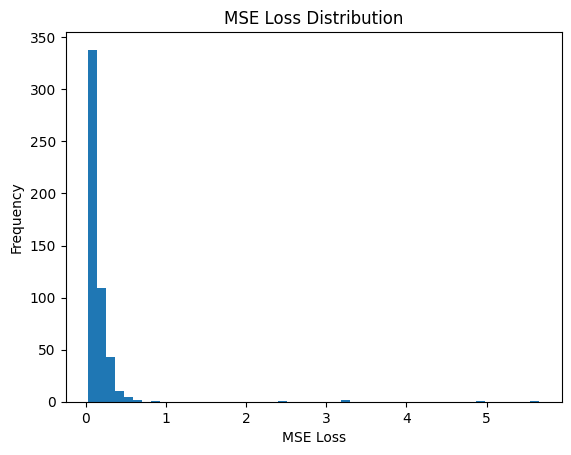

In [380]:
import matplotlib.pyplot as plt

# Create a histogram of the MSE loss distribution
plt.hist(mse_loss, bins=50)
plt.xlabel("MSE Loss")
plt.ylabel("Frequency")
plt.title("MSE Loss Distribution")
plt.show()


In [381]:
test_data

,windspeed,tpw,rainfall,mse_loss
452,10.317814,0.015783,4.692294,0.082538
2220,15.215410,0.012037,3.435439,0.075458
627,18.014168,0.041853,8.395069,0.101518
1155,14.473034,0.009904,6.975924,0.116501
2210,10.722096,0.006533,9.556436,0.157565
...,...,...,...,...
321,17.937977,0.008743,27.543498,0.554908
2505,27.123528,0.037294,32.042267,0.687422
386,18.557990,0.041031,24.467809,0.320401
2534,5.484813,0.160226,21.900691,0.425903


In [382]:
df_sorted = test_data.sort_values('mse_loss', ascending=False)

In [383]:
df_max = df_sorted.nlargest(129, 'mse_loss')


In [384]:
threshold=np.mean(df_max["mse_loss"])


In [385]:
test_data['predicted_rainfall_class'] = np.where(test_data['mse_loss'] > threshold, 'extreme', 'normal')
test_data[test_data["mse_loss"]>threshold]

,windspeed,tpw,rainfall,mse_loss,predicted_rainfall_class
1480,15.113218,0.293077,18.144288,0.425503,extreme
2489,8.407922,0.423654,13.688682,0.546055,extreme
872,16.671124,0.385539,12.060663,0.454925,extreme
1231,14.385685,0.486403,15.168206,0.595551,extreme
1128,17.300350,0.399276,16.839862,0.510171,extreme
1233,18.075144,0.291965,20.783703,0.435340,extreme
2084,17.062350,0.453411,17.020622,0.567346,extreme
1230,13.123178,0.451620,7.625555,0.496424,extreme
1343,12.654827,0.550524,34.993438,3.258388,extreme
2433,4.516322,0.058479,26.762055,2.405528,extreme


In [386]:
test_data['rainfall_class'] = 'normal'
test_data.loc[test_data.index.isin(filtered_data.index), 'rainfall_class'] = 'extreme'


In [387]:
test_data

,windspeed,tpw,rainfall,mse_loss,predicted_rainfall_class,rainfall_class
452,10.317814,0.015783,4.692294,0.082538,normal,normal
2220,15.215410,0.012037,3.435439,0.075458,normal,normal
627,18.014168,0.041853,8.395069,0.101518,normal,normal
1155,14.473034,0.009904,6.975924,0.116501,normal,normal
2210,10.722096,0.006533,9.556436,0.157565,normal,normal
...,...,...,...,...,...,...
321,17.937977,0.008743,27.543498,0.554908,extreme,extreme
2505,27.123528,0.037294,32.042267,0.687422,extreme,extreme
386,18.557990,0.041031,24.467809,0.320401,normal,extreme
2534,5.484813,0.160226,21.900691,0.425903,extreme,extreme


In [407]:
#test_data[test_data['predicted_rainfall_class']  == test_data['rainfall_class']].count()


windspeed                   26
tpw                         26
rainfall                    26
mse_loss                    26
predicted_rainfall_class    26
rainfall_class              26
actual_rainfall_binary      26
dtype: int64

In [408]:
wrong_predictions = test_data[test_data['predicted_rainfall_class'] != test_data['rainfall_class']]


percentage_of_error=(wrong_predictions.shape[0]/test_data.shape[0])*100

# Print the wrong predictions
print("wrong predictions = ",wrong_predictions.shape[0])
print("total data = ",test_data.shape[0])
print("percentage of error = ",percentage_of_error)

wrong predictions =  26
total data =  513
percentage of error =  5.0682261208577


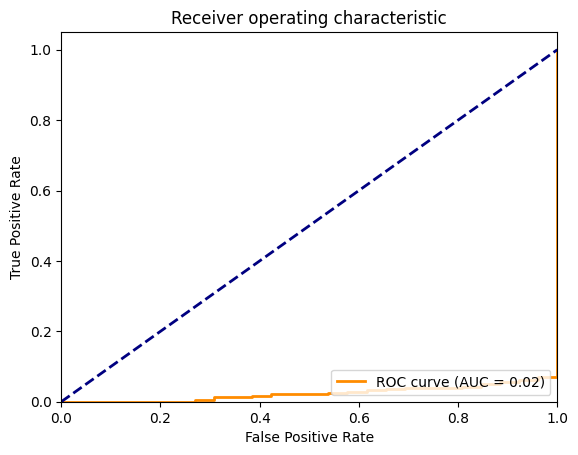

Best threshold: 6.65548835619125


In [409]:
test_data['actual_rainfall_binary'] = (test_data['predicted_rainfall_class'] == test_data['rainfall_class'])
#test_data['actual_rainfall_binary'] = (test_data['predicted_rainfall_class'] == 'extreme') & (test_data['rainfall_class'] == 'extreme')

fpr, tpr, thresholds = roc_curve(test_data['actual_rainfall_binary'], test_data['mse_loss'])
roc_auc = auc(fpr, tpr)
# Calculate TNR
tnr = 1 - fpr

# Calculate Youden's J statistic for each threshold
j_stat = tpr + tnr - 1

# Find the index of the threshold that maximizes J
best_threshold_idx = np.argmax(j_stat)

# Get the best threshold
best_threshold = thresholds[best_threshold_idx]

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# Print the best threshold
print("Best threshold:", best_threshold)

In [390]:
threshold=best_threshold

In [391]:
test_data['predicted_rainfall_class'] = np.where(test_data['mse_loss'] > threshold, 'extreme', 'normal')
test_data[test_data["mse_loss"]>threshold]

,windspeed,tpw,rainfall,mse_loss,predicted_rainfall_class,rainfall_class,actual_rainfall_binary


In [ ]:
wrong_predictions = test_data[test_data['predicted_rainfall_class'] != test_data['rainfall_class']]


percentage_of_error=(wrong_predictions.shape[0]/test_data.shape[0])*100

# Print the wrong predictions
print("wrong predictions = ",wrong_predictions.shape[0])
print("total data = ",test_data.shape[0])
print("percentage of error = ",percentage_of_error)

In [ ]:
num_correct = len(test_data[test_data['predicted_rainfall_class'] == test_data['rainfall_class']])
num_total = len(test_data)
accuracy = num_correct / num_total * 100
print('Accuracy: {:.2f}%'.format(accuracy))